In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
import seaborn as sns

In [78]:
test_data = np.array([1.73, 1.8, 1.85, 1.79, 3.0]).reshape(-1, 1)
aprx_est = np.array([np.mean(np.delete(test_data, i)) for i in range(test_data.shape[0])]).reshape(-1, 1)

sensitivity = np.max(np.abs(np.mean(aprx_est) - aprx_est))
pvals_type1 = []
pvals_power = []

def dp(loo_mean):
    all_noise = np.full(loo_mean.shape[1], np.nan)

    for p_loo_mean in range(loo_mean.shape[1]):
        loo_estimate = loo_mean[:, p_loo_mean]
        true_mean = np.mean(loo_estimate)
        sensitivity = np.max(np.abs(true_mean - loo_estimate)) 
        noise = np.random.laplace(loc=0.0, scale=sensitivity)
        
        all_noise[p_loo_mean] = noise
    
    return all_noise

n = test_data.shape[0]
iterations = 1000
alpha = 0.05
effect_size = 0.5
type1_errors = 0
powers = 0

for mu in [np.mean(test_data), effect_size]:
    reject_count = 0
    pvals = []
    for _ in range(iterations):
        sample = np.random.normal(loc=mu, scale=sensitivity, size=5).reshape(-1, 1)
        aprx_est = np.array([np.mean(np.delete(sample, i)) for i in range(n)]).reshape(-1, 1)
        noise = dp(aprx_est)
        noisy_means = aprx_est.flatten() + noise.flatten()
        t_stat, p_val = ttest_1samp(noisy_means, popmean=np.mean(aprx_est))
        pvals.append(p_val)
        if p_val < alpha:
            reject_count += 1

    if mu == np.mean(test_data):
        type1_errors = reject_count / iterations
        pvals_type1 = pvals
    else:
        powers = reject_count / iterations
        pvals_power = pvals
    

## Bar chart for Type I Error and Power


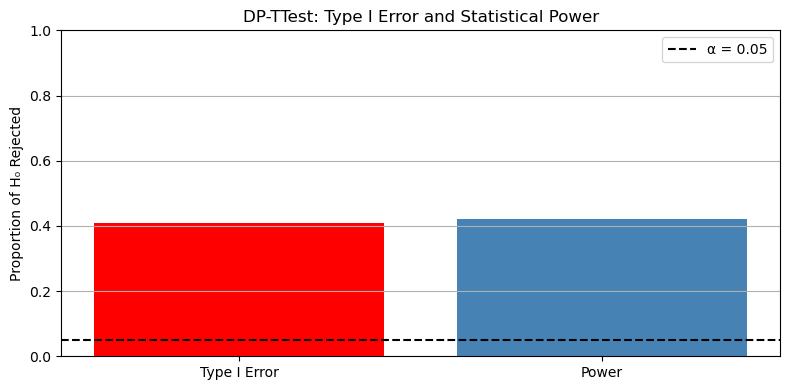

In [79]:
plt.figure(figsize=(8, 4))

bars = plt.bar(["Type I Error", "Power"], [type1_errors, powers], color=["red", "steelblue"])
plt.axhline(alpha, color="black", linestyle="--", label="α = 0.05")
plt.title("DP-TTest: Type I Error and Statistical Power")
plt.ylim(0, 1)
plt.ylabel("Proportion of H₀ Rejected")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## Histogram of p-values under H0 and H1 

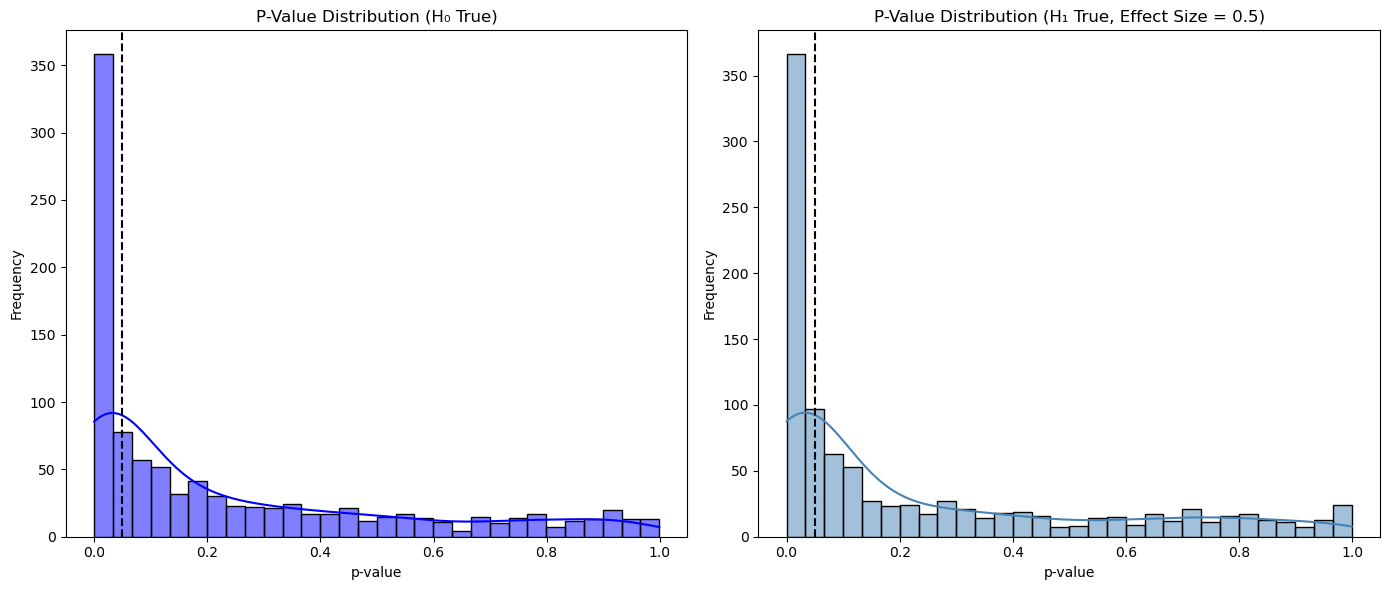

In [80]:

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(pvals_type1, bins=30, ax=axs[0], color="blue", kde=True)
axs[0].axvline(alpha, color="black", linestyle="--")
axs[0].set_title("P-Value Distribution (H₀ True)")
axs[0].set_xlabel("p-value")
axs[0].set_ylabel("Frequency")

sns.histplot(pvals_power, bins=30, ax=axs[1], color="steelblue", kde=True)
axs[1].axvline(alpha, color="black", linestyle="--")
axs[1].set_title("P-Value Distribution (H₁ True, Effect Size = 0.5)")
axs[1].set_xlabel("p-value")
axs[1].set_ylabel("Frequency")



plt.tight_layout()
plt.show()


## Power vs. Sample Size Curve

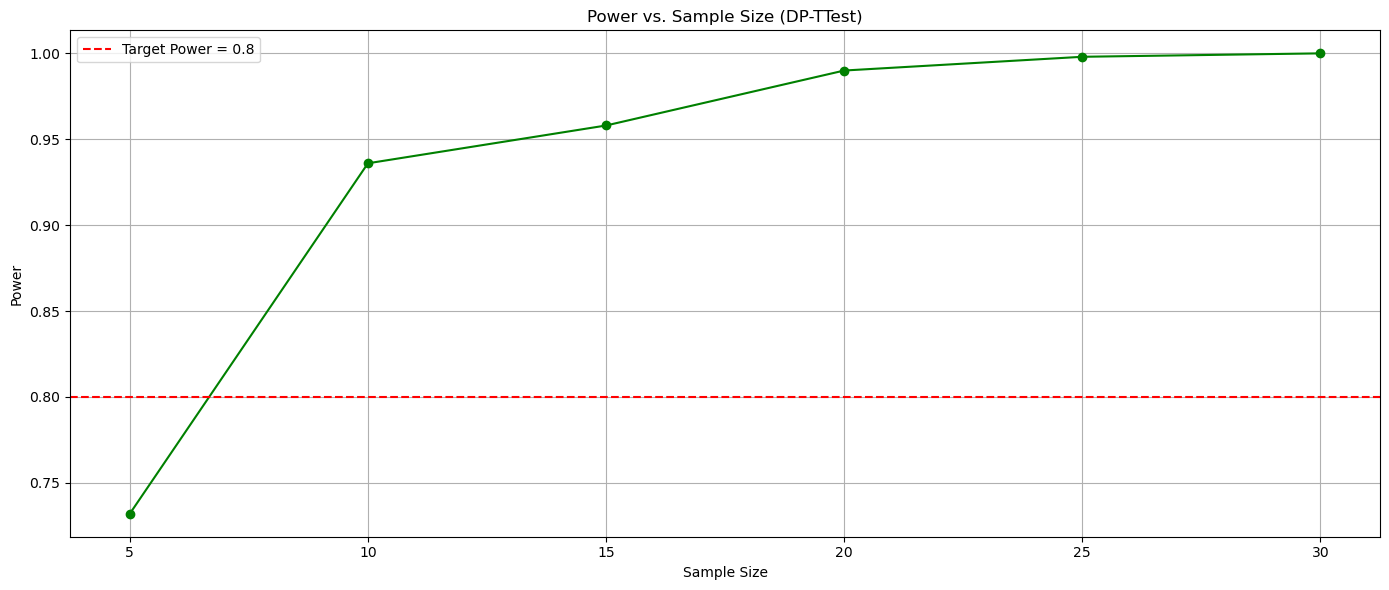

In [81]:
plt.figure(figsize=(14, 6))
plt.plot(sample_sizes, power_curve, marker='o', color="green")
plt.title("Power vs. Sample Size (DP-TTest)")
plt.xlabel("Sample Size")
plt.ylabel("Power")
plt.axhline(0.8, linestyle="--", color="red", label="Target Power = 0.8")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
